# Part 1   SQL
Below SQL query works for MySQL workbench 8.0.19

## Question 1: Story Performance

### Calculate average purchases per reader per story for September 2021 and rank stories based on this with the highest purchases per reader.


Event names can have following values: “read”, “purchase”.
We have the following table with table Name: events
- user_id (int)
- event_name (string) 
- story (string)
- chapter (int)
- timestamp (datetime)




### Answer: create 3 temp tables and use dense_rank

'''

with a as 
(select story_id, count(distinct user_id) as t_reader
from events 
where extract(year_month from time_stamp)=202109
group by story_id),

b as 
(select story_id, count(*) as t_purchase
from events
where event_name ='purchase'
and extract(year_month from time_stamp)=202109
group by story_id),

c as(
select ifnull(t_purchase/t_reader,0) as purchase_per_reader, a.story_id as story
from a left join b
on a.story_id = b.story_id)


select story, purchase_per_reader,
dense_rank() over (order by purchase_per_reader desc) as rk
from c


'''

## Question 2：Subscriptions

### Calculate the total revenue per month from subscriptions, once including renewal revenues, and once excluding renewal revenues


Subscriptions with three events:
- "purchase": a user purchases a subscription ( 1-month and 12-month subscriptions).
- "renewal": an existing subscription renews automatically (exactly after the subscription period ends)
- "cancel": a user cancels her subscription (the subscription will continue running up to the end of the current subscription period, but won't renew)

The event data is collected in the following table with table Name: events

- user_id (int)
- event_name (string)
- subscription_name (string, the type of subscription purchased) 
- price (float)
- subscription_id (int, identifier of the individual subscription) 
- timestamp (datetime)


### Answer: case when function with 2 temp table
'''


with a as(
select user_id,event_name,price, subscription_id,time_stamp
from events
where event_name ='purchase'),

b as (
select aa.user_id,aa.event_name,a.price,aa.subscription_id,aa.time_stamp
from events aa left join a 
on aa.subscription_id= a.subscription_id
where aa.event_name ='renewal' 
union 
select * from a)


select left(time_stamp,7) as month,
sum(price) as subscription_revenue,
sum(case when event_name='purchase' then price else 0 end) as subscription_revenue_excl_renewal
from b
group by  left(time_stamp,7)
order by  left(time_stamp,7)


'''

# Part 2 Python

We have the following table columns:

- user_id
- event_name
- story_id - chapter
- timestamp


## Set Up

In [334]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## The Data

In [323]:
df=pd.read_csv('/Users/Tony/opt/Python/inkitt_task_20220520/challenge_data.csv')
df.head()

,user_id,event_name,chapter,story_id,time_stamp
0,12368931004b5f19081648ee2d065813,chapter_read,40,82f3ba6152e2d14cff7d4dc1ad59fa82,2020-03-01 01:19:53.162
1,daf5c7a61e0dbaceafeae87621ab5738,chapter_read,1,984225c9eb92d8c57332b30c257a4bc4,2020-03-01 02:35:12.591
2,3503b5e5d53b2e848d577f489af277b8,chapter_read,15,984225c9eb92d8c57332b30c257a4bc4,2020-03-01 05:36:31.220
3,5a5de7a039a2022f42f2e93785c9bb13,chapter_read,31,f758f45045148009b412e71f5ac709ea,2020-03-01 06:52:10.671
4,5a5de7a039a2022f42f2e93785c9bb13,chapter_read,32,f758f45045148009b412e71f5ac709ea,2020-03-01 07:08:24.003


In [144]:
df.shape

(743260, 5)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743260 entries, 0 to 743259
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     743260 non-null  object
 1   event_name  743260 non-null  object
 2   chapter     743260 non-null  int64 
 3   story_id    743260 non-null  object
 4   time_stamp  743260 non-null  object
dtypes: int64(1), object(4)
memory usage: 28.4+ MB


## Data Cleaning
Here are some of the tasks I performed for cleaning my data.

### Null value
Found out No null values in the dataframe

In [146]:
df.isnull().sum()

user_id       0
event_name    0
chapter       0
story_id      0
time_stamp    0
dtype: int64

In [147]:
df.describe()

,chapter
count,743260.000000
mean,24.273479
std,22.781148
min,1.000000
25%,7.000000
50%,17.000000
75%,34.000000
max,121.000000


### Missing data 
1. chapter_start lack of the data before 2020-06-11
2. In order to calculate in the same time scope, replace df with data that dose not include data before min(story2.time_stamp)

In [324]:
story1 = story[story.event_name == 'chapter_read']
story2 = story[story.event_name == 'chapter_start']

In [325]:
max(story1.time_stamp)

'2020-11-30 23:59:55.338'

In [149]:
min(story1.time_stamp)

'2020-06-11 15:37:14.783'

In [150]:
max(story2.time_stamp)

'2020-11-30 23:59:54.849'

In [151]:
min(story2.time_stamp)

'2020-06-11 15:36:35.216'

In [326]:
df = df[df.time_stamp >= min(story2.time_stamp)]
df

,user_id,event_name,chapter,story_id,time_stamp
10738,04256314a8fc097373775589c9c8386a,chapter_read,44,82f3ba6152e2d14cff7d4dc1ad59fa82,2020-06-11 15:57:21.833
10739,fdb07da51c433e5118e785bd373b32ec,chapter_read,49,82f3ba6152e2d14cff7d4dc1ad59fa82,2020-06-11 16:09:50.278
10740,6cb9b0a3834967f9a9006c672c282ba3,chapter_read,60,82f3ba6152e2d14cff7d4dc1ad59fa82,2020-06-11 17:12:20.283
10741,667dbb2f64bd9c6c4288d856c140b1d9,chapter_read,3,984225c9eb92d8c57332b30c257a4bc4,2020-06-11 17:29:46.021
10742,c1bd509bf448889704180f68ebac178d,chapter_read,15,984225c9eb92d8c57332b30c257a4bc4,2020-06-11 17:36:41.747
...,...,...,...,...,...
743255,734b5b49751af044255e573cb9b61676,chapter_start,3,3575eddf5a35f068c2b2b5fd791b903c,2020-11-30 23:41:05.885
743256,47b28e955ec64e470df1264c7b257ca9,chapter_start,10,82f3ba6152e2d14cff7d4dc1ad59fa82,2020-11-30 23:41:20.323
743257,06931a215a381eb3f006622f918d2b1f,chapter_start,16,f3c17a78b6dc925afcd802a560b7be58,2020-11-30 23:44:08.223
743258,036d2680f4b7a74cf67db120194c6c23,chapter_start,7,984225c9eb92d8c57332b30c257a4bc4,2020-11-30 23:45:30.310


### Duplicate

In [319]:
df.duplicated().sum()

0

## Question a:
1. Calculate chapter retention rates (for a given story chapter: (# readers of chapter / (# starters of the story)) 
2. visualise them in a way that allows to compare them across stories. 
3. Based on these rates, which story performs best?



In [227]:
#Function which takes the dataframe and book(story_id) as input
def Retention(df,book):
 cohort_read=df[(df['event_name']== 'chapter_read') &(df['story_id'] == book)]
 cohort_start=df[(df['event_name']== 'chapter_start')&(df['story_id'] == book)]
#The denominator is constant: distinct count of user_id with event_name in chapter_start for each story 
 cohort_data=pd.DataFrame((cohort_read.groupby(['chapter'])['user_id'].count()/cohort_start['user_id'].nunique()*100).round(1))
 return cohort_data

chapter                            1     2     3     4     5     6     7    \
CohortIndex                                                                  
3575eddf5a35f068c2b2b5fd791b903c  44.0  38.5  36.6  35.1  34.3  33.5  32.5   
5e295aa27b052369f88efb753358d9e1  78.1  68.1  63.7  59.7  55.4  53.0  49.9   
6f74e35447551639ff626c145f20d0af  33.0  29.7  27.8  26.5  24.9  23.7  22.8   
82f3ba6152e2d14cff7d4dc1ad59fa82  37.9  32.3  30.1  28.2  27.4  26.6  25.8   
984225c9eb92d8c57332b30c257a4bc4  36.3  29.2  26.8  24.7  24.2  23.5  22.8   
f3c17a78b6dc925afcd802a560b7be58  43.8  39.0  36.8  35.5  34.2  32.9  31.3   
f758f45045148009b412e71f5ac709ea  55.9  48.6  45.4  43.5  41.5  40.6  39.4   

chapter                            8     9     10   ...  111  112  113  114  \
CohortIndex                                         ...                       
3575eddf5a35f068c2b2b5fd791b903c  31.8  30.8  29.0  ...  NaN  NaN  NaN  NaN   
5e295aa27b052369f88efb753358d9e1  46.1  43.7  40.7  ...  NaN

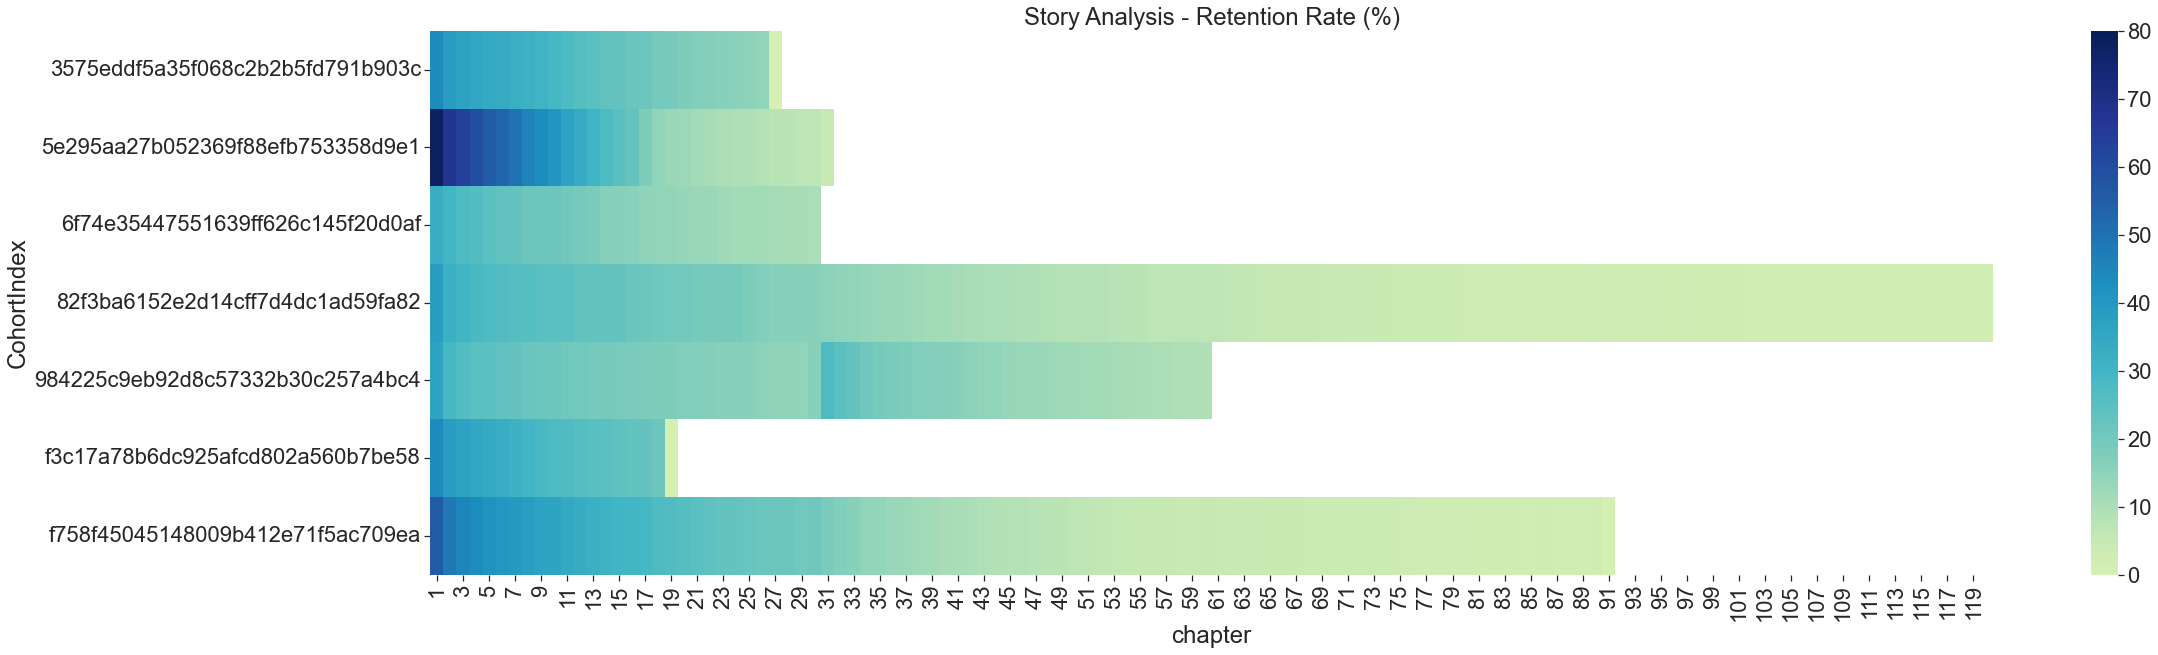

In [238]:
book=['82f3ba6152e2d14cff7d4dc1ad59fa82',
       '984225c9eb92d8c57332b30c257a4bc4',
       '6f74e35447551639ff626c145f20d0af',
       'f758f45045148009b412e71f5ac709ea',
       '3575eddf5a35f068c2b2b5fd791b903c',
       'f3c17a78b6dc925afcd802a560b7be58',
       '5e295aa27b052369f88efb753358d9e1']
ret_0= Retention(df, '82f3ba6152e2d14cff7d4dc1ad59fa82')
ret_1= Retention(df, '984225c9eb92d8c57332b30c257a4bc4')
ret_2= Retention(df, '6f74e35447551639ff626c145f20d0af')
ret_3= Retention(df, 'f758f45045148009b412e71f5ac709ea')
ret_4= Retention(df, '3575eddf5a35f068c2b2b5fd791b903c')
ret_5= Retention(df, 'f3c17a78b6dc925afcd802a560b7be58')
ret_6= Retention(df, '5e295aa27b052369f88efb753358d9e1')

ret_0['CohortIndex']=  '82f3ba6152e2d14cff7d4dc1ad59fa82'
ret_1['CohortIndex']=  '984225c9eb92d8c57332b30c257a4bc4'
ret_2['CohortIndex']=  '6f74e35447551639ff626c145f20d0af'
ret_3['CohortIndex']=  'f758f45045148009b412e71f5ac709ea'
ret_4['CohortIndex']=  '3575eddf5a35f068c2b2b5fd791b903c'
ret_5['CohortIndex']=  'f3c17a78b6dc925afcd802a560b7be58'
ret_6['CohortIndex']=  '5e295aa27b052369f88efb753358d9e1'



ret_0.insert(0, 'chapter', range(1, 1 + len(ret_0)))
ret_1.insert(0, 'chapter', range(1, 1 + len(ret_1)))
ret_2.insert(0, 'chapter', range(1, 1 + len(ret_2)))
ret_3.insert(0, 'chapter', range(1, 1 + len(ret_3)))
ret_4.insert(0, 'chapter', range(1, 1 + len(ret_4)))
ret_5.insert(0, 'chapter', range(1, 1 + len(ret_5)))
ret_6.insert(0, 'chapter', range(1, 1 + len(ret_6)))


perc_list=[ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6]
cohort_count= pd.concat(perc_list)
cohort_pivot= cohort_count.pivot(index='CohortIndex', 
 columns='chapter', values='user_id')
print(cohort_pivot)
#plot
plt.figure(figsize = (35,10))
plt.title('Story Analysis - Retention Rate (%)')
sns.heatmap(data = cohort_pivot, 
            annot = False,
            cbar = True,
            fmt='0.3g',
            vmin = 0,
            vmax = 80,
            center = 30,
            cmap = "YlGnBu")
plt.xlabel('chapter')
plt.show()

### Analysis
Above figure shows a heatmap for the chapter retention each for each story_id. The higher the retention rate, the darker the color. Below are some of the findings based on this figure.

1. From the heatmap, we can see story_id:'5e295aa27b052369f88efb753358d9e1' with the highest retention rate(78.1%) on the chapter 1. And retention rate still remain high throughout the half of the story.
2. '6f74e35447551639ff626c145f20d0af' with the lowest retention rate (33%) in the beginning.
3. Each story has a different chapter length. '82f3ba6152e2d14cff7d4dc1ad59fa82' has the most chapters.
4. '3575eddf5a35f068c2b2b5fd791b903c' and 'f3c17a78b6dc925afcd802a560b7be58' no one reads the last chapter even though there are not many chapters

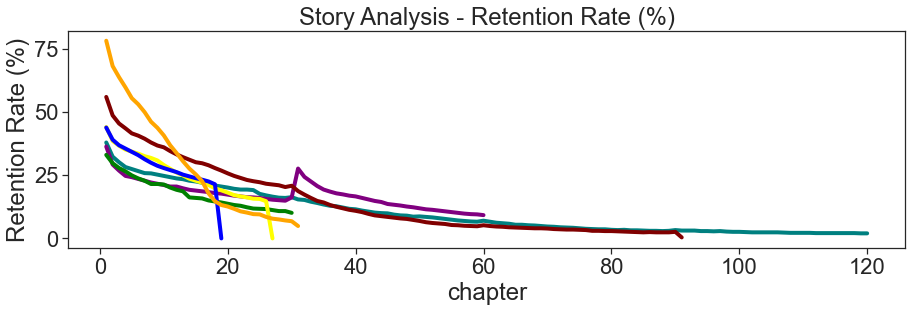

In [327]:
ret_0= Retention(df, '82f3ba6152e2d14cff7d4dc1ad59fa82')
ret_1= Retention(df, '984225c9eb92d8c57332b30c257a4bc4')
ret_2= Retention(df, '6f74e35447551639ff626c145f20d0af')
ret_3= Retention(df, 'f758f45045148009b412e71f5ac709ea')
ret_4= Retention(df, '3575eddf5a35f068c2b2b5fd791b903c')
ret_5= Retention(df, 'f3c17a78b6dc925afcd802a560b7be58')
ret_6= Retention(df, '5e295aa27b052369f88efb753358d9e1')
# plot
sns.set(font_scale=2,rc={'figure.figsize':(15, 4)})
sns.set_palette('brg',3)
sns.set_style('ticks')
fig, ax = plt.subplots()
ret_0.plot(ax=ax, linewidth=4, color='teal', label='book1')
ret_1.plot(ax=ax, linewidth=4, color='purple', label='2')
ret_2.plot(ax=ax, linewidth=4, color='green', label='34')
ret_3.plot(ax=ax, linewidth=4, color='maroon', label='567')
ret_4.plot(ax=ax, linewidth=4, color='yellow', label='82')
ret_5.plot(ax=ax, linewidth=4, color='blue', label='fa82')
ret_6.plot(ax=ax, linewidth=4, color='orange', label='59fa82')


plt.xlabel('chapter')
plt.ylabel('Retention Rate (%)')
plt.title('Story Analysis - Retention Rate (%)')
ax.get_legend().remove()

### Analysis
Similarly, line charts can be used to compare different stories.

1. We can see that the orange line at the beginning has a much higher retention rate than other stories. Orange line :'5e295aa27b052369f88efb753358d9e1'，so this also supports the first analysis of the heat map.
2. The purple line('984225c9eb92d8c57332b30c257a4bc4') holds the highest retention rate at the end of the story.

### Use coefficient of variation to compare the performance

In [338]:
def cv(data):
    mean = np.mean(data)
    std = np.std(data, ddof = 0)
    num_cv = std/mean
    return num_cv

data1 = Retention(df, '82f3ba6152e2d14cff7d4dc1ad59fa82')
data2 = Retention(df, '984225c9eb92d8c57332b30c257a4bc4')
data3 = Retention(df, '6f74e35447551639ff626c145f20d0af')
data4 = Retention(df, 'f758f45045148009b412e71f5ac709ea')
data5 = Retention(df, '3575eddf5a35f068c2b2b5fd791b903c')
data6 = Retention(df, 'f3c17a78b6dc925afcd802a560b7be58')
data7 = Retention(df, '5e295aa27b052369f88efb753358d9e1')



print('CV1',cv(data1))
print('CV2',cv(data2))
print('CV3',cv(data3))
print('CV4',cv(data4))
print('CV5',cv(data5))
print('CV6',cv(data6))
print('CV7',cv(data7))

CV1 user_id    0.857091
dtype: float64
CV2 user_id    0.308066
dtype: float64
CV3 user_id    0.34905
dtype: float64
CV4 user_id    0.921695
dtype: float64
CV5 user_id    0.378042
dtype: float64
CV6 user_id    0.316791
dtype: float64
CV7 user_id    0.7438
dtype: float64


### Analysis
1. Because each story has a different number of chapters, it cannot be directly compared. Here I introduce the coefficient of variation, also known as the coefficient of dispersion, which is a statistic that measures the degree of dispersion of the data： is the ratio of the standard deviation to the mean.
2. The coefficient of variation of the retention rate of '984225c9eb92d8c57332b30c257a4bc4'  is the smallest, that is to say, the retention rate as a whole is maintained at a level that does not change much from the mean.At the same time, it still has the highest retention rate at the end of the story, so from this perspective this story performs best.
3. '5e295aa27b052369f88efb753358d9e1'：The retention rate was the highest initially but the overall retention rate fluctuated widely.

## Question b:
1. Which other metrics measuring story performance can you think of? Feel free to calculate those that can be constructed based on the above data. For those you are missing data for, please explain what kind of data you’d like to use. 
2. Please briefly describe pros and cons of the metrics you identified, especially in relation to chapter retention rates from a).

In [156]:
#create a new column with year&month data
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [159]:
df['yr_mnth'] = df['time_stamp'].apply(lambda x: x.strftime('%Y-%m'))

In [161]:
df.yr_mnth.unique()

array(['2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11'],
      dtype=object)

### readers of chapter / starters of chapter
1. The retention rate in the question a can be used to compare different stories. This indicator is to achieve the comparison between different chapters of the same story, to evaluate which chapter the user started in but did not read it. The user can be further studied in the future. Reason for giving up.
2. Read_perc = readers of chapter / starters of chapter
3. The advantage of this indicator is that it can compare different chapters of the same story. The downside is that because the denominator changes, this metric doesn't look like the overall retention rate is declining, so it can't be compared with other stories.

In [330]:
#Function which takes the dataframe and book(story_id) as input
def Read_perc(df,book):
 cohort_read=df[(df['event_name']== 'chapter_read') &(df['story_id'] == book)]
 cohort_start=df[(df['event_name']== 'chapter_start')&(df['story_id'] == book)]
#The denominator is constant: distinct count of user_id with event_name in chapter_start for each story 
 cohort_data=pd.DataFrame((cohort_read.groupby(['chapter'])['user_id'].count()/cohort_start.groupby(['chapter'])['user_id'].count()*100).round(1))
 return cohort_data

In [331]:
Read_perc(df,'82f3ba6152e2d14cff7d4dc1ad59fa82')

,user_id
chapter,
1,49.5
2,94.3
3,94.9
4,94.1
5,95.7
...,...
117,85.0
118,83.9
119,80.8


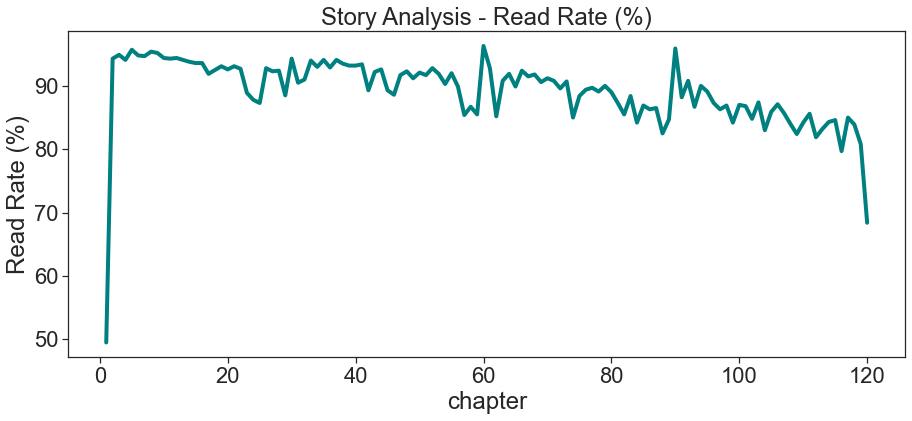

In [293]:
read_perc_0= Read_perc(df, '82f3ba6152e2d14cff7d4dc1ad59fa82')

# plot
sns.set(font_scale=2,rc={'figure.figsize':(15, 6)})
sns.set_palette('brg',3)
sns.set_style('ticks')
fig, ax = plt.subplots()
ret_0.plot(ax=ax, linewidth=4, color='teal')

plt.xlabel('chapter')
plt.ylabel('Read Rate (%)')
plt.title('Story Analysis - Read Rate (%)')
ax.get_legend().remove()

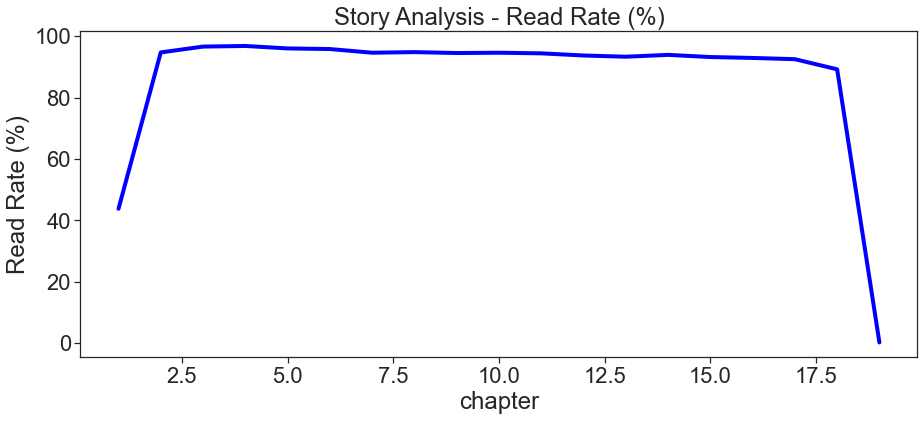

In [300]:
read_perc_5= Read_perc(df, 'f3c17a78b6dc925afcd802a560b7be58')

# plot
sns.set(font_scale=2,rc={'figure.figsize':(15, 6)})
sns.set_palette('brg',3)
sns.set_style('ticks')
fig, ax = plt.subplots()
ret_5.plot(ax=ax, linewidth=4, color='blue')

plt.xlabel('chapter')
plt.ylabel('Read Rate (%)')
plt.title('Story Analysis - Read Rate (%)')
ax.get_legend().remove()

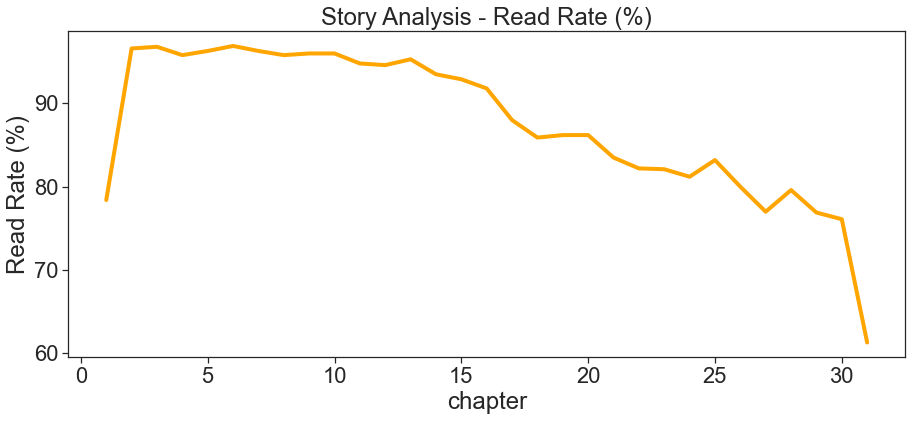

In [301]:
read_perc_6= Read_perc(df, '5e295aa27b052369f88efb753358d9e1')

# plot
sns.set(font_scale=2,rc={'figure.figsize':(15, 6)})
sns.set_palette('brg',3)
sns.set_style('ticks')
fig, ax = plt.subplots()
ret_6.plot(ax=ax, linewidth=4, color='orange')

plt.xlabel('chapter')
plt.ylabel('Read Rate (%)')
plt.title('Story Analysis - Read Rate (%)')
ax.get_legend().remove()

### Analysis
In the above three pictures, I listed the reading rate of each chapter of the three stories.
1. '82f3ba6152e2d14cff7d4dc1ad59fa82'：There are many chapters, but except for the low reading rate at the beginning, the overall reading rate fluctuates but is relatively stable.
2. 'f3c17a78b6dc925afcd802a560b7be58'：Most of the reader churn is at the beginning of the story, and once the reader has read it, it will continue to read.
3. '5e295aa27b052369f88efb753358d9e1'：The story maintains a high read rate until chapter 10, and the overall trend declines significantly with chapters. Explain that it is possible for the story to be very engaging in the first half of the story but less attractive from chapter 10 onwards.

### Monthly active users
1. This indicator is to compare the size of active users of different stories, as well as the change of users over the month.
2. Monthly active users = Number of distinct users per story per month.
3. The advantage of this metric is that you can see whether the audience for the story is niche or popular, and you can see monthly changes. The disadvantage is that this number may be affected by many factors, such as the overall active number of applications, advertising influence, etc., so this metric can be combined with retention rate.

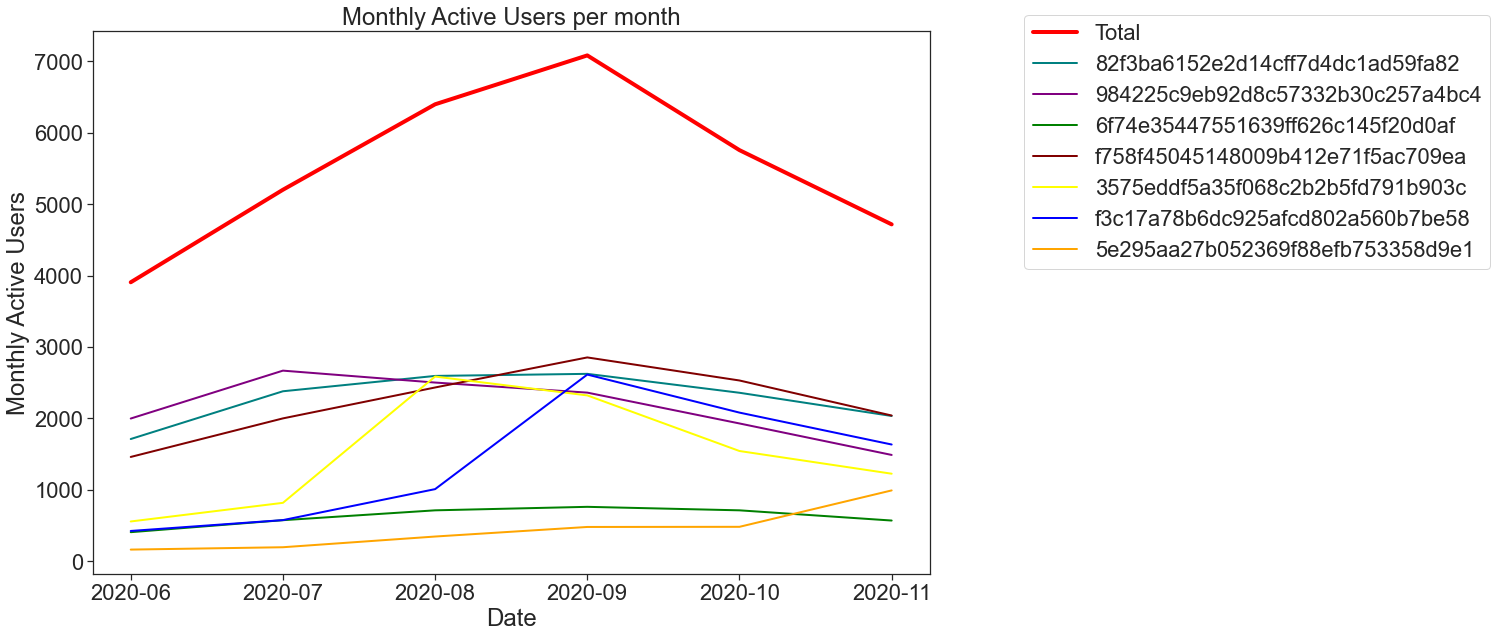

In [306]:
# Users which read or start book1 82f3ba6152e2d14cff7d4dc1ad59fa82
dfu1= df[df['story_id']=='82f3ba6152e2d14cff7d4dc1ad59fa82']['user_id'].unique() 
df_book1 = df[(df['user_id'].isin(dfu1))]
df_book1.head()
dfu2= df[df['story_id']=='984225c9eb92d8c57332b30c257a4bc4']['user_id'].unique() 
df_book2 = df[(df['user_id'].isin(dfu2))]
df_book2.head()
dfu3= df[df['story_id']=='6f74e35447551639ff626c145f20d0af']['user_id'].unique() 
df_book3 = df[(df['user_id'].isin(dfu3))]
df_book3.head()
dfu4= df[df['story_id']=='f758f45045148009b412e71f5ac709ea']['user_id'].unique() 
df_book4 = df[(df['user_id'].isin(dfu4))]
df_book4.head()
dfu5= df[df['story_id']=='3575eddf5a35f068c2b2b5fd791b903c']['user_id'].unique() 
df_book5 = df[(df['user_id'].isin(dfu5))]
df_book5.head()
dfu6= df[df['story_id']=='f3c17a78b6dc925afcd802a560b7be58']['user_id'].unique() 
df_book6 = df[(df['user_id'].isin(dfu6))]
df_book6.head()
dfu7= df[df['story_id']=='5e295aa27b052369f88efb753358d9e1']['user_id'].unique() 
df_book7 = df[(df['user_id'].isin(dfu7))]
df_book7.head()


# Month active users for users who read or start book1
month_active_book1= df_book1.groupby(['yr_mnth']).nunique()['user_id']
month_active_book2= df_book2.groupby(['yr_mnth']).nunique()['user_id']
month_active_book3= df_book3.groupby(['yr_mnth']).nunique()['user_id']
month_active_book4= df_book4.groupby(['yr_mnth']).nunique()['user_id']
month_active_book5= df_book5.groupby(['yr_mnth']).nunique()['user_id']
month_active_book6= df_book6.groupby(['yr_mnth']).nunique()['user_id']
month_active_book7= df_book7.groupby(['yr_mnth']).nunique()['user_id']



# Total Number of active users
month_active_users= df.groupby(['yr_mnth']).nunique()['user_id']
# plot
sns.set(font_scale=2,rc={'figure.figsize':(15, 10)})
sns.set_palette("brg",3)
sns.set_style("ticks")
fig, ax = plt.subplots()
month_active_users.plot(ax=ax, linewidth=4, label='Total', color='red')
month_active_book1.plot(ax=ax, linewidth=2, label='82f3ba6152e2d14cff7d4dc1ad59fa82', color='teal')
month_active_book2.plot(ax=ax, linewidth=2, label='984225c9eb92d8c57332b30c257a4bc4', color='purple')
month_active_book3.plot(ax=ax, linewidth=2, label='6f74e35447551639ff626c145f20d0af', color='green')
month_active_book4.plot(ax=ax, linewidth=2, label='f758f45045148009b412e71f5ac709ea', color='maroon')
month_active_book5.plot(ax=ax, linewidth=2, label='3575eddf5a35f068c2b2b5fd791b903c', color='yellow')
month_active_book6.plot(ax=ax, linewidth=2, label='f3c17a78b6dc925afcd802a560b7be58', color='blue')
month_active_book7.plot(ax=ax, linewidth=2, label='5e295aa27b052369f88efb753358d9e1', color='orange')


plt.xlabel("Date")
plt.ylabel("Monthly Active Users")
plt.title("Monthly Active Users per month")
plt.legend(bbox_to_anchor=(1.1, 1.05))

### Analysis
This line graph shows the active users of each story between June and November 2020. The red line is the total number of active users (assuming the current application only has these 7 books).
1. In 2020-06, this three colors(purple '984225c9eb92d8c57332b30c257a4bc4'  & teal '82f3ba6152e2d14cff7d4dc1ad59fa82' & maroon 'f758f45045148009b412e71f5ac709ea') had significantly more users than the other four stories.
2. The trend of the blue line（'f3c17a78b6dc925afcd802a560b7be58'） is the same as the Total trend: there was a clear uptick in September.
3. There was an obvious increase in the number of users of the yellow line in August, which was not caused by the overall environment. It may need to be analyzed in combination with other marketing data and advertising data.
4. The user volume of the green（'6f74e35447551639ff626c145f20d0af'） and orange（'5e295aa27b052369f88efb753358d9e1'） lines is significantly smaller, with around 500 active users. At the same time, we can find that although the audience of orange（'5e295aa27b052369f88efb753358d9e1'） is small, the retention rate of the audience is high.